# Gaussian Process

All notes are taken from the book _Gaussian Process for Machine Learning_ by Rasmussen et. al.

- Regression is a common machine learning task where we're given a training dataset and we try to find a function that represents that dataset as closely as possible and use that function to make predictions on new datasets.
- GP defines a distribution over functions, a generalization of the Gaussian probability distribution
- Stochastic process that governs the properties of functions

## 2 Regression

In [2]:
import numpy as np
from scipy import stats
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns
import pandas as pd

### 2.1 Weight-space View

We take a Bayesian treatment of the linear model and then project the inputs into a high-dimensional feature space and apply that linear model there.
- Training set $D=\{(x_i,y_i) \vert i=1,\ldots,n\}$ where $x$ input vector (covariates) with dimension $d$ and $y$ is target variable.
- Write $x$ as an $d$x$n$ design matrix $X$ and targets are in a $n$x$1$ vector $Y$, so $D=(X,Y)$.
- Interest: conditional distribution of the targets given the inputs
- $f(X)=X^Tw$, $Y=f(X)+\epsilon$ where $w$ is the $beta$ parameters, and $\epsilon \sim N(0,\sigma_n^2)$.
- Likelihood: probability density of observations given the parameters. $p(Y\vert X,w)=N(X^Tw,\sigma_n^2I)$.
- Must specify prior over the parameters (beliefs about parameters before observing data). Let $p(w)=N(0,\Sigma_p)$.
- Posterior: $p(w\vert X,Y) = N(\frac{1}{\sigma_n^2}A^{-1}XY,A^{-1})$ where $A=\sigma_n^2XX^T + \Sigma_p^{-1}$. The mean of this distro is also the mode, called maximum a posteriori (MAP)
- Predictive distro: average over all possible parameter values, weighted by their posterior probability to make predictions for a test case. The predictive distribution for $f_* = f_*(x_*)$ at $x_*$ is: $p(f_*\vert X_*,X,Y) = N(\frac{1}{\sigma_n^2}X_*^TA^{-1}XY,X_*^TA^{-1}X_*)$

In [3]:
#Example: 1-d input space with D=p=2 weight-space
x_data = [[-5,2,5]]
x_data = np.array(x_data)
df = pd.DataFrame(x_data)

#Numer of dimensions, or parameters:
p = len(df) + 1 #number of rows in x_data + 1 for intercept

#Number of observations:
n = len(df.columns)

#Insert row of 1s for the intercept
df.loc[-1] = np.ones(n)  # adding a row
df.index = df.index + 1  # shifting index
df = df.sort_index()  # sorting by index

#Training set D of n observations:
X = df.to_numpy() #X: Dxn design matrix. 1x3 in this case
XT = np.atleast_2d(X).T #X': nxD matrix --> 3x1

Dy = np.array([-5.5,0.5,4.5]) #1xn vector --> 1x3
y = np.atleast_2d(Dy).T #nx1 vector --> 3x1

Figure 2.1 a). Specify prior. Example: with $p=2$ we have $\mu = [\mu_1,\mu_2] = [0,0]^T$ and $\begin{pmatrix} \sigma^2_1 & \sigma_{12} \\ \sigma_{21} & \sigma^2_2 \end{pmatrix} = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix}$.

$$ \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} \sim \mathcal{N}\left(\begin{pmatrix} \mu1 \\ \mu_2 \end{pmatrix}, \begin{pmatrix} \sigma^2_1 & \sigma_{12} \\ \sigma_{21} & \sigma^2_2 \end{pmatrix}\right) \sim \mathcal{N}(\mu, \Sigma)$$

In [4]:
mu = np.zeros(p) #0 mean Gaussian prior
Sigmap = np.identity(p)#covariance matrix
s = np.random.multivariate_normal(mu, Sigmap, 1000)

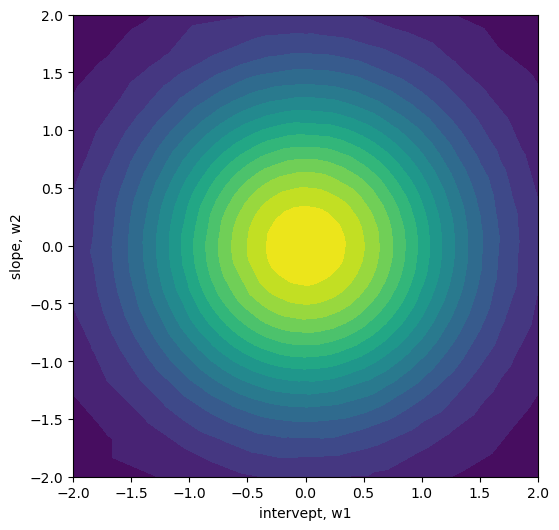

In [5]:
w1 = s[:,0]
w2 = s[:,1]
z = multivariate_normal.pdf(s, mean=mu, cov=Sigmap)

plt.figure(figsize=(6,6))
plt.tricontourf(w1, w2, z,levels=15)
plt.xlabel("intervept, w1"); plt.ylabel("slope, w2")
plt.axis([-2, 2, -2, 2])
plt.show()

Figure 2.1 b). Insert three training points given the prior. Sumperimpose predictive mean plus/minus two standard deviations of the predictive distribution.

In [6]:
#Data to predict:
xstar_data = [np.linspace(-5.8,5.8,num=1000)]
df2 = pd.DataFrame(xstar_data)

#Number of observations:
nstar = len(df2.columns)

#Insert row of 1s for the intercept
df2.loc[-1] = np.ones(nstar)  # adding a row
df2.index = df2.index + 1  # shifting index
df2 = df2.sort_index()  # sorting by index

#Training set D of n observations:
Xstar = df2.to_numpy() #X: Dxn design matrix. 1x3 in this case
XstarT = np.atleast_2d(Xstar).T #X': nxD matrix --> 3x1

#assume that sigma_n^2 = 1
sigman = 1 #std
A = sigman**(-2)*np.matmul(X,XT) + np.linalg.inv(Sigmap)
Ainv = np.linalg.inv(A)

In [7]:
#Superimpose on the data the predictive mean with +- 2 std
#Predictive mean:
print(XstarT.shape,Ainv.shape,X.shape,y.shape)
mean_predict = sigman**(-2)*XstarT@Ainv@X@y
mean_predict = mean_predict.T[0]
print(mean_predict.shape)

(1000, 2) (2, 2) (2, 3) (3, 1)
(1000,)


In [8]:
#Predictive var:
print(XstarT.shape,Ainv.shape,Xstar.shape)
var_predict = XstarT@Ainv@Xstar
print(var_predict.shape)

(1000, 2) (2, 2) (2, 1000)
(1000, 1000)


In [9]:
#Error bars of predictive distribution
s = np.random.multivariate_normal(mean_predict, var_predict, 100) #take 100 samples
#average of s is mean_predict
error_bar = 2*np.sqrt(np.var(s,axis = 0)) #axis=0 is var along rows, axis=1 is var along cols

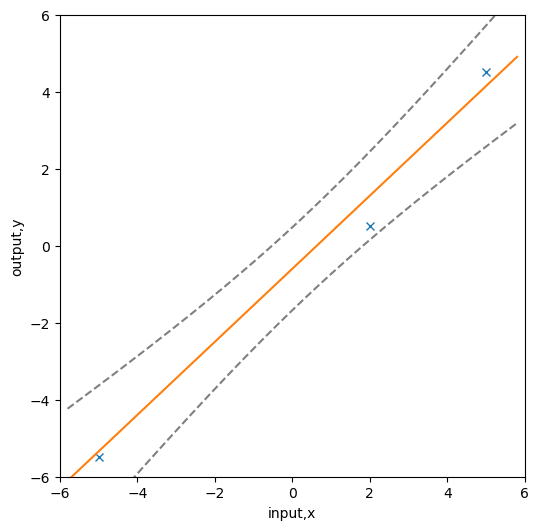

In [10]:
plt.figure(figsize=(6,6))
#X*
plt.plot(x_data[0],Dy,marker='x',linestyle='')
#predictive mean:
plt.plot(xstar_data[0],mean_predict)
#2std above and below predivitve mean:
plt.plot(xstar_data[0],mean_predict+error_bar,linestyle='--',color="grey")
plt.plot(xstar_data[0],mean_predict-error_bar,linestyle='--',color="grey")

plt.xlabel("input,x"); plt.ylabel("output,y")
plt.axis([-6, 6, -6, 6])
plt.show()

### 2.2 Function-space View

A Gaussian Process describes a distribution over functions, completely specified by its mean and covariance function. It can be seen as a stochastic process that defines properties of functions, like a generalization of a Gaussian probability distribution. The mean function is
$$
	m(x) = E[f(x)],
$$
the covariance function, or kernel, is
$$
	k(x,x') = E[(f(x)-m(x))(f(x')-m(x'))],
$$
and together they form a Gaussian process:
$$
	f(x) \sim GP(m(x),k(x,x')).
$$
It is the specification of the covariance function that implies the distribution over functions which we choose before we observe the training dataset. Thus, this specification also defines the family of functions we would use to fit the training data, giving us our prior.

#### Intuition behind the prior

Say our region of interest to perform regression is $[0,1]$, the region where our training dataset would fall. Within that region, there are infinitely many possible functions from a certain family of functions that could pass through that region. The specification of that family of functions is the prior. To illustrate this, say we create an $n$x$1$ vector of $n=30$ evenly spaced $x$ values on $[0,1]$. We then generate a random $n$x$1$ vector $y$ from a multivariate normal distribution with a mean of $0$ and an identity covariance. If we connect each point $(x_i,y_i)$ sequentially in $i\in 1\ldots n$, the result is a linear spline on $[0,1]$, which we see in figure

Figure 1: A linear spline through $n=30$ evenly distributed $x$ values on $[0,1]$. Since the covariance is independent of the $x$ values, the $y$ values can take on any value, hence the jagged shape.

Text(0, 0.5, '$Y$')

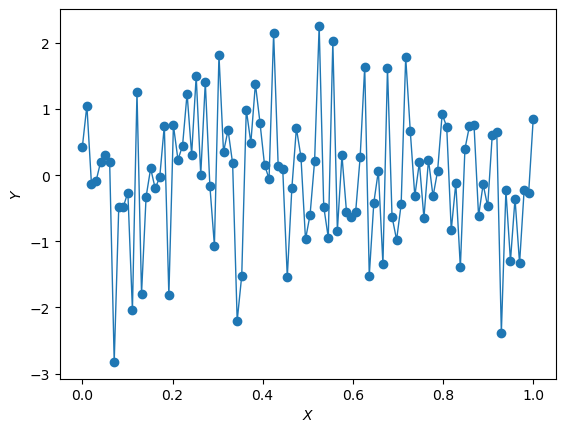

In [70]:
n = 100 #number of x values
m = 1 #number of functions

mean = np.zeros(n)
cov = np.eye(n)

f_prior = np.random.multivariate_normal(mean, cov, m).T

Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

plt.clf()
for i in range(m):
    plt.plot(Xshow, f_prior, '-o', linewidth=1)
    
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')

There are infinitely many such linear splines on $[0,1]$ where the domain of our training data is on the $n=30$ evenly spaced $x$ values. This figure illustrates this idea with five more possible splines.

Figure 2: A family of $6$ linear splines through $n=30$ evenly distributed $x$ values on $[0,1]$.

Text(0, 0.5, '$Y$')

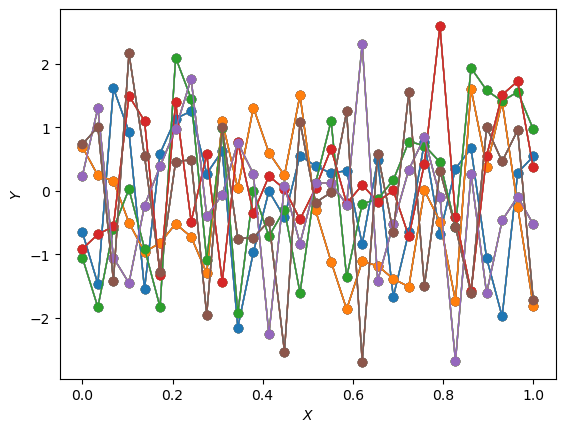

In [65]:
n = 30 #number of x values
m = 6 #number of functions

mean = np.zeros(n)
cov = np.eye(n)

f_prior = np.random.multivariate_normal(mean, cov, m).T

Xshow = np.linspace(0, 1, n).reshape(-1,1)   # n number test points in the range of (0, 1)

plt.clf()
for i in range(m):
    plt.plot(Xshow, f_prior, '-o', linewidth=1)
    
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')

Now say we'd like to fit a smooth linear spline on $n=30$ evenly spaced $x$ values. This would require us to correlate each element $y_i$ in the vector $y$, which we can do smoothly by specifying a covariance function on $x$ for the covariance part of the multivariate normal distribution.

We use the Squared Exponential Kernel, also called Radial Basis Function Kernel or Gaussian Kernel, as our covariance function:
\begin{equation}\label{eq:1}
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp\left(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j)\right)
\end{equation}
where $\sigma_f$ and $l$ are hyperparameters. In this example, this would result in a $n$x$n$ covariance matrix $K$ where each element is $\kappa(x_i,x_j)$ with $x_i,x_j$ taken from the $n$ evenly spaced $x$ values for all $i,j\in \{1\ldots,n\}$.

Figure 3: A smooth linear spline through $n=30$ evenly distributed $x$ values on $[0,1]$. 

In [81]:
# Define the kernel
def kernel(a, b):
    #Hyperparameters:
    kernelParameter_l = 0.3
    kernelParameter_sigma = 1.0
    
    #Kernel:
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    sqexpo = (kernelParameter_sigma**2)*np.exp(-.5 * (1/(kernelParameter_l**2)) * sqdist)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return sqexpo

Text(0, 0.5, '$Y$')

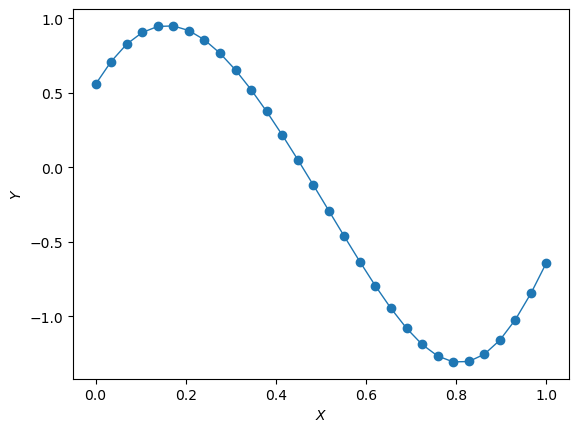

In [82]:
n = 30  
m = 1

# 1) Create grid of evenly spaced points X in [0,1]
Xshow = np.linspace(0, 1, n).reshape(-1,1) #reshape turns to column vect

# 2) Define kernel
K = kernel(Xshow, Xshow) # k(x_star, x_star)        

# 3) Define prior
mean = np.zeros(n)
f_prior = np.random.multivariate_normal(mean, K, m).T


plt.clf()
for i in range(m):
    plt.plot(Xshow, f_prior, '-o', linewidth=1)
    
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')

An alternative way to generate correlated normally distributed random samples $y$ is to first generate uncorrelated samples, and then multiply them by a matrix $L$ such that $L L^T = K$, where $L$ is a lower triangular matrix created by a Cholesky decomposition of $K$. The Cholesky decomposition is a decomposition of a Hermitian, positive-definite matrix into the product of a lower triangular matrix and its conjugate transpose, which is useful for efficient numerical solutions. We generate the plots in figure with five more possible smooth splines.

Figure 4: A family of $6$ smooth linear splines through $n=30$ evenly distributed $x$ values on $[0,1]$, defined by a Cholesky decomposition of the squared exponential kernel.

Text(0, 0.5, '$Y$')

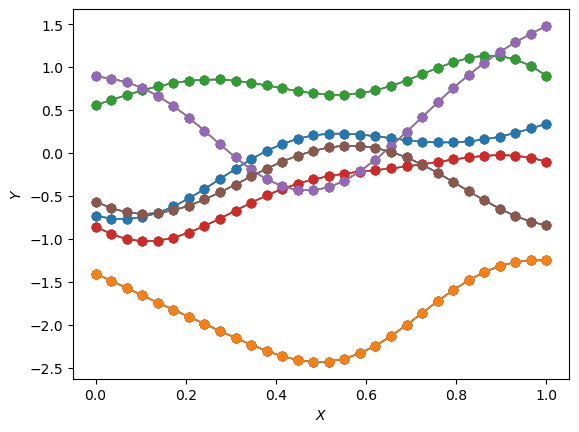

In [67]:
n = 30  
m = 6

# 1) Create grid of evenly spaced points X in [0,1]
Xshow = np.linspace(0, 1, n).reshape(-1,1) #reshape turns to column vect

# 2) Define kernel
K = kernel(Xshow, Xshow) # k(x_star, x_star)   

#3) Cholesky decomposition of the kernel.
L = np.linalg.cholesky(K + 1e-6*np.eye(n))

# 4) Define prior
f_prior = np.dot(L, np.random.normal(size=(n,m)))


plt.clf()
for i in range(m):
    plt.plot(Xshow, f_prior, '-o', linewidth=1)
    
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')

Now let's fit a smooth linear spline on infinity many evenly spaced $x$ values on $[0,1]$. Like before, we would have to generate a random $n$x$1$ vector $y$ from a multivariate normal distribution with a $n$x$1$ mean vector of $0$ and a $n$x$n$ covariance matrix $K$, but this time $n\rightarrow \infty$. Generating a random vector $y$ from an infinitely dimensional multivariate normal distribution means that for all inputs $x_i\in x=[0,1]$, there exists a function $f: x\rightarrow y$ such that $y_i=f(x_i)$ for all $i$. Hence the function space view, where we view the set of all continuous functions on $[0,1]$ as an infinitely dimensional vector space. The prior specifies the family of such continuous functions. Figure illustrates this idea where we sample $100$ random vectors from an $n=150$-dimensional multivariate normal distribution. Notice that these $100$ random vectors looks like a set of $100$ smooth, continuous functions on $[0,1]$.

Figure 5: A sample of $100$ random vectors from an $n=150$-dimensional multivariate normal distribution.

Text(0, 0.5, '$Y$')

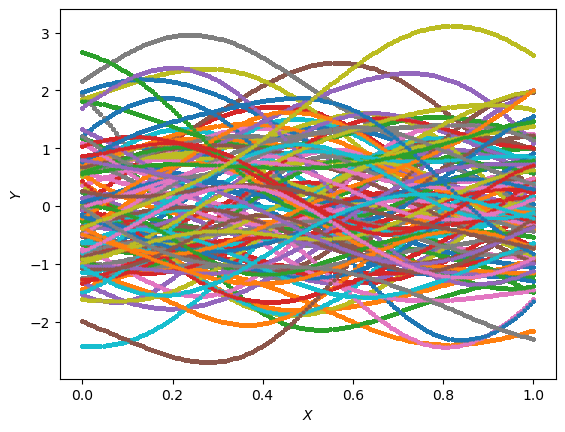

In [75]:
n = 150 
m = 100

# 1) Create grid of evenly spaced points X in [0,1]
Xshow = np.linspace(0, 1, n).reshape(-1,1) #reshape turns to column vect

# 2) Define kernel and mean
K = kernel(Xshow, Xshow) # k(x_star, x_star)   
mean = np.zeros(n)

# 3) Define prior
f_prior = np.random.multivariate_normal(mean, K, m).T


plt.clf()
for i in range(m):
    plt.plot(Xshow, f_prior, 'o', linewidth=1, markersize=2, markeredgewidth=1)
    
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')

#### The Posterior

While the prior represents the functions we expect to see over possible inputs $x$, the posterior keeps the functions that fit the training data points. When we observe more training points, our previous posterior becomes a prior, and we use the new training points to update our posterior. 

This entire process, from prior to posterior, is called a Gaussian Process (GP). Hence the definition, that it is an infinitely dimensional multivariate normal probability distribution over functions, which can be seen as infinitely dimensional vectors, that fit our observations. Since this is a probability distribution, we must have a mean function and variance.

To see this mathematically, if we choose a set of input points $X_*$ on our domain, we can generate a random vector, or function, from this distribution:
$$f_* \sim N(0,K(X_*,X_*))$$
where $f_* = f(X_*)$, and $K(X_*,X_*)$ is the covariance matrix generated by elements $K_{ij} = k(x_{*i},x_{*j})$ for all $i,j$ from $1,\ldots,n_*$ with $n_* = \lvert X_* \rvert$. This is equivalent to drawing a random function from a GP prior. However, we want to predict $f(X_*)$ on test points $X_*$ given $n$ training inputs $X$ with training outputs $Y=f(X)$. This naturally leads to a conditional distribution of $f$, our posterior, which we derive below.

The joint distribution of $\mathbf{f}$ and $\mathbf{f}_*$ can be modeled as:
\begin{equation}\label{eq2}
\begin{pmatrix} f \\ f_*\end{pmatrix} \sim N\left(\begin{pmatrix}m(X)\\ m(X_*)\end{pmatrix}, \begin{pmatrix}K & K_* \\ K_*^T & K_{**}\end{pmatrix}\right)
\end{equation}
where $K = k(X, X)$ is a $n$x$n$ covariance matrix whose elements are evaluated at all pairs of training points, similarly for $K_* = k(X, X_*)$ and $K_{**}=k(X_*, X_*)$, and $\begin{pmatrix}m(X)\\ m(X_*)\end{pmatrix} = \mathbf{0}$. This is modeling a joint distribution $p(f, f_* \, \vert \, X, X_*)$, but we want the conditional distribution over $f_*$ only, which is $p(f_* \, \vert \, f, X, X_*)$. The derivation process from the joint distribution $p(f,f_* \, \vert \, X, X_*)$ to the conditional $p(f_* \, \vert \, f, X, X_*)$ is shown by Rasmussen et al (also shown here: https://statproofbook.github.io/P/mvn-cond.html). The resulting posterior distribution is as follows
\begin{equation}\label{eq3}
	f_* \, \vert \, f, X, X_* \sim N\left(K_*^T K^{-1} f, \: K_{**}-K_*^T K^{-1} K_*\right)
\end{equation}
The function values $f_*$ corresponding to test inputs $X_*$ can now be sampled from this joint posterior distribution.

Realistically, we do not have access to function values $f$ but only noisy versions $y = f(x) + \epsilon$ where $\epsilon \sim N(0,\sigma_n^2)$, the prior on the noisy observations becomes $cov(y) = K + \sigma_n^2\mathbf{I}$. The joint distribution of the observed target values and the function values at the test locations is now

\begin{equation}\label{eq4}
\begin{pmatrix} y \\ f_*\end{pmatrix} \sim N\left(\mathbf{0}, \begin{pmatrix}K + \sigma_n^2\mathbf{I} & K_* \\ K_*^T & K_{**}\end{pmatrix}\right)
\end{equation}

Re-deriving the conditional distribution from equation, we get the following posterior distribution
\begin{equation}\label{eq5}
	f_* \, \vert \, X, y, X_* \sim N \left(\bar{f}_*, cov(f_*)\right) 
\end{equation}
where
\begin{equation}\label{eq6}
	\bar{f}_* \overset{\Delta}{=} \mathbb{E} [\bar{f}_* \, \vert \, X, y, X_*] = K_*^T [K + \sigma_y^2\mathbf{I}]^{-1} y
\end{equation}
and
\begin{equation}\label{eq7}
	cov(f_*) = K_{**} - K_*^T [K + \sigma_y^2\mathbf{I}]^{-1} K_* 
\end{equation}

#### Example:

Say the true unknown function we would like to approximate is $f(x) = \sin(0.9x)$ on the domain $[-5,5]$. See figure.

Figure 6: $f(x) = \sin(0.9x)$ is the true function we would like to approximate.

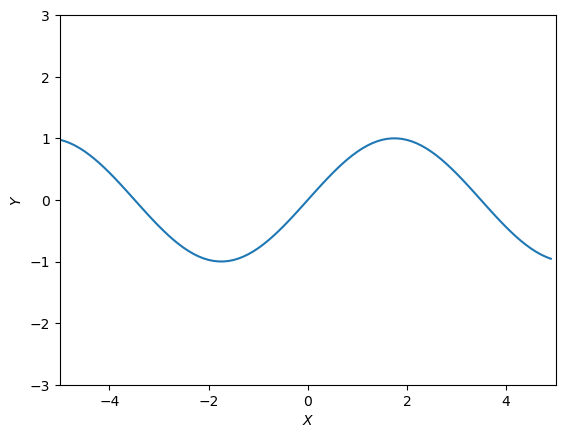

In [83]:
# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()
x = np.arange(-5, 5, 0.1)

plt.plot(x, f(x))
plt.axis([-5, 5, -3, 3])
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

To implement a GPR on this example, we follow Algorithm 2.1 in Rasmussen et al. Find the coding implementation in the appendix.
1. **Set up**. On the domain $[-5,5]$, we have $n=15$ training inputs $X$, $n_*=200$ testing inputs $X_*$, and target variables $y = f(X) + \epsilon$ where $\epsilon \sim N(0,\sigma^2_n)$. We choose $\sigma^2_n = 0.0005$.
	
2. **Define the kernel**. Define the kernel $K = K(X,X)$ and then define a new kernel $K_{noise}$ that takes noisy observations into account, $K_{noise} = K_{noise}(X,X) = K + \sigma^2_n\mathbf{I}$. Lastly, define the kernels $K_* = K(X,X_*)$ and $K_{**} = K(X_*,X_*)$. Do a Cholesky decomposition $K_{noise} = LL^T$. For the purpose of example we use the squared exponential kernel, the most popular covariance function, with hyperparameters $l = 0.3$ and $\sigma_f = 1.0$.
	
3. **Find the predictive mean at the test points**.
		$$\bar{f_*} = K_*^T(K+\sigma^2_nI)^{-1}y = K_*^T(K_{noise})^{-1}y = K_*^T(LL^T)^{-1}y$$
		Let $\alpha = (LL^T)^{-1}y$. Then
		$$\bar{f_*} = K_*^T\alpha$$
		If $\alpha = (LL^T)^{-1}y$, then $y = LL^T\alpha$. Then $L\backslash y = L^T\alpha$. Then $\alpha = L^T\backslash (L\backslash y) = (L^T)^{-1}L^{-1}y$. If we write 
		$$\bar{f_*} = K_*^T(LL^T)^{-1}y = K_*^T(L^T)^{-1}L^{-1}y =  [K_*^T(L^T)^{-1}][L^{-1}y] = v^Tb,$$
		we solve for $v^T$ by $$Lv = K_*$$
		$$v = L\backslash K_* = L^{-1} K_*$$
		$$v^T = (L^{-1} K_*)^T = K_*^T (L^{-1})^T$$
		and for $b$ by
		$$Lb = y$$
		$$b = L\backslash y = L^{-1}y$$
        
4. **Find the predictive variance at the test points**.
		$$cov(f_*) = K_{**} - K_*^T(K_{noise})^{-1}K_* = K_{**} - K_*^T(LL^T)^{-1}K_*$$
		$$= K_{**} - K_*^T(L^T)^{-1}L^{-1}K_* = K_{**} - K_*^T(L^{-1})^TL^{-1}K_* = K_{**} - v^Tv$$
		We only care about the diagonal elements of $cov(f_*)$ to give us the variance of $f_*$. Let $\text{diag}()$ take the diagonal elements of an $n_*$x$n_*$ matrix. Then,
		$$V[f_*] = \text{diag}\left(cov(f_*)\right) = \text{diag}\left(K_{**} - v^Tv\right).$$

In [118]:
# Define the kernel
def kernel(a, b):
    #Hyperparameters:
    kernelParameter_l = 1.94 #0.3 #1.94
    kernelParameter_sigma = 1.75 #1.0 #1.75
    
    #Kernel:
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    sqexpo = (kernelParameter_sigma**2)*np.exp(-.5 * (1/(kernelParameter_l**2)) * sqdist)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return sqexpo

In [119]:
## 1) Setup
N = 15         # number of existing observation points (training points) X
n = 200        # number of test points X*
s = 0.0005    # noise variance sigma_X^2

np.random.seed(100)
X = np.random.uniform(-5, 5, size=(N,1))     # N training points 
mu_X,sigma_X = 0,np.sqrt(s)
y = f(X) + s*np.random.normal(mu_X,sigma_X,N) #observations (following true unknown function we wish to approx)

## 2) Define kernel and cholesky decompose:
K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(N))

## 3) Predictive mean at test points
Xtest = np.linspace(-5, 5, n).reshape(-1,1)
v = np.linalg.solve(L, kernel(X, Xtest))   #v = L^{-1} k_*
b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
mu = np.dot(v.T, b) #f_* = v^Tb

## 4) Predictive variance at test points
Kstar = kernel(Xtest, Xtest) #this is a diagonal matrix since x_p = x_q in k(x_p,x_q)  
sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
var = np.diag(sigma)
std = np.sqrt(var)

Figure 7: The blue line is the function we want to approximate, the "+" symbols are the $n=15$ training points $X$, the dashed red line is the predictive mean, and the shaded region is the uncertainty of two predictive standard deviations.

<Figure size 640x480 with 0 Axes>

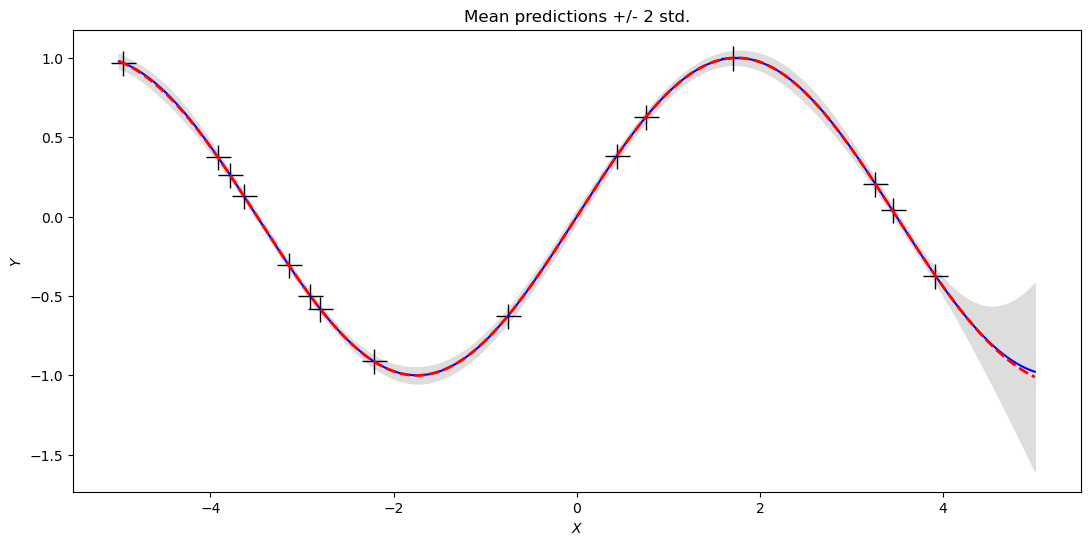

In [120]:
## PLOT
plt.clf()
plt.figure(figsize=(13,6))

# Plot training data
plt.plot(X, y, 'k+', ms=18)
# Plot test points
plt.plot(Xtest, f(Xtest), 'b-')
# Plot predictive mean
plt.plot(Xtest, mu, 'r--', lw=2)
# Plot 2std above and below predictive mean
plt.gca().fill_between(Xtest.flat, mu-2*std, mu+2*std, color="#dddddd")

plt.title('Mean predictions +/- 2 std.')
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

To visualize the posterior distribution, we take $40$ random samples of $f_*$ to get figure

Figure 8: The "+" symbols are the $n=15$ training points $X$, the dashed red line is the predictive mean, and we have $40$ samples of $f_*$ from the posterior distribution. Notice how the peaks and troughs of $f_*$ visually match the shape of the shaded uncertainty in the previous figure.

<Figure size 640x480 with 0 Axes>

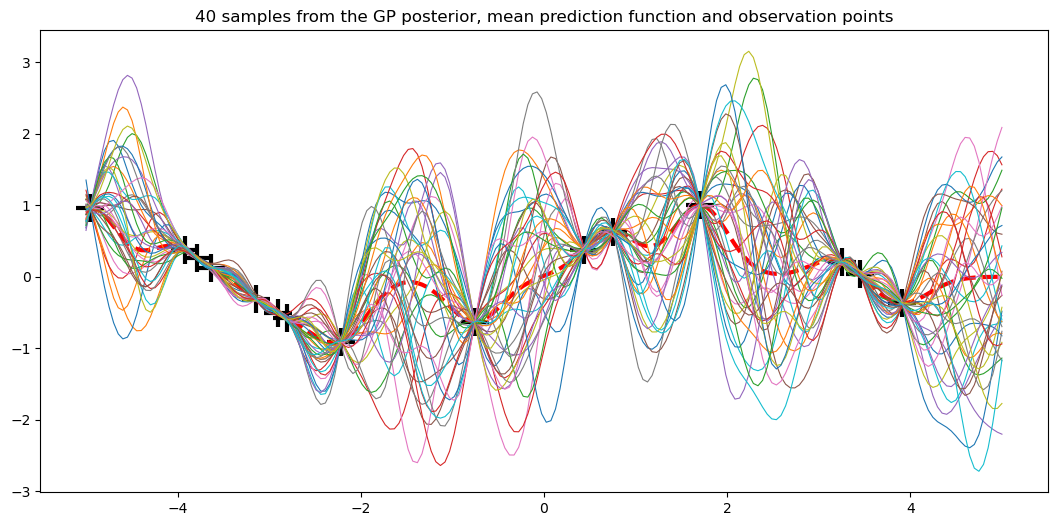

In [105]:
m = 40
f_post = np.random.multivariate_normal(mu,sigma,40).T

## Plot of 40 samples from the GP posterior, along w
plt.clf()
plt.figure(figsize=(13,6))
#Plot training data:
plt.plot(X, y, 'k+', markersize=20, markeredgewidth=3)
#PLot predictive mean:
plt.plot(Xtest, mu, 'r--', linewidth=3)
#Plot samples from the GP posterior
plt.plot(Xtest, f_post, linewidth=0.8)
plt.title('40 samples from the GP posterior, mean prediction function and observation points')
plt.show()

Given $x$, what is $y$? Without training data, we have no idea. Now given our above training data, we can make predictions:

In [92]:
def conditional(Xtest_val,X,y,kernel,N):
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X)
    L = np.linalg.cholesky(K + s*np.eye(N)) 

    ## 3) Predictive mean at test points
    Xtest = np.asarray([Xtest_val]).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest) #this is a diagonal matrix since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    s2 = np.diag(sigma)

    return print("Expected value for x = %i: y = %.4f with uncertainty = %.4f" % (Xtest_val, mu, s2) )

conditional(2,X,y,kernel,N)

Expected value for x = 2, 0.9238 with uncertainty = 0.0322


## 4 Covariance Functions

- _Stationary_ covariance function is a function $x-x'$. It is invariant to translations in input space. Ex: squared exponential kernel.
- _Isotropic_ covariance function if it is a function of $\lvert x-x' \rvert$. Ex: squared exponential kernel.
- _Dot product_ covariance function if it depends only on $x$ and $x'$ through $x\cdot x'$. Ex: $k(x,x') = \sigma_0^2 + x\cdot x'$ from linear regression with $N(0,1)$ priors on the coefficients of $x_d$ and a prior of $N(0,\sigma_0^2)$ on the bias $1$. Another is the polynomail kernel $k(x,x') = (\sigma_0^2+x\cdot x')^p$. They're invariant to rotation of coordinates but not translations.
- _Gram matrix, or covariance matrix, K_ whose entries are $K_{ij} = k(x_i,x_j)$. It is a positive semidefinite matrix.

In [67]:
## Define functions: ##
%matplotlib notebook
from ipywidgets import *
import matplotlib.pyplot as plt


# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()


def kernel(a, b, kernelParameter_l, kernelParameter_sigma):
    #Hyperparameters:
    #kernelParameter_l = 1.94 #0.3 #1.94
    #kernelParameter_sigma = 1.75 #1.0 #1.75
    
    #Kernel:
    sqdist = np.sum(a**2,axis=1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    sqexpo = (kernelParameter_sigma**2)*np.exp(-.5 * (1/(kernelParameter_l**2)) * sqdist)
    # np.sum( ,axis=1) means adding all elements columnly; .reshap(-1, 1) add one dimension to make (n,) become (n,1)
    return sqexpo


def posterior(X,s,y,kernelParameter_l, kernelParameter_sigma):
    N = len(X)
    n = 200 # number of test points X*
    
    ## 2) Define kernel and cholesky decompose:
    K = kernel(X, X, kernelParameter_l, kernelParameter_sigma)
    L = np.linalg.cholesky(K + s*np.eye(N))

    ## 3) Predictive mean at test points
    Xtest = np.linspace(-5, 5, n).reshape(-1,1)
    v = np.linalg.solve(L, kernel(X, Xtest, kernelParameter_l, kernelParameter_sigma))   #v = L^{-1} k_*
    b = np.linalg.solve(L, y) #b = L\backslash y = L^{-1}y
    mu = np.dot(v.T, b) #f_* = v^Tb

    ## 4) Predictive variance at test points
    Kstar = kernel(Xtest, Xtest, kernelParameter_l, kernelParameter_sigma) #this is a diag mat since x_p = x_q in k(x_p,x_q)  
    sigma = Kstar - np.dot(v.T,v) # = np.diag(Kstar) - np.sum(v**2, axis=0)  
    var = np.diag(sigma)
    std = np.sqrt(var)
    
    return Xtest, mu, std


def plot_post(X,s,y,kernelParameter_l, kernelParameter_sigma):
    #Return mu and std:
    Xtest, mu, std = posterior(X,s,y,kernelParameter_l, kernelParameter_sigma)
    
    ## PLOT
    plt.clf()
    plt.figure(figsize=(6.5,3))

    # Plot training data
    plt.plot(X, y, 'k+', ms=18)
    # Plot test points
    plt.plot(Xtest, f(Xtest), 'b-')
    # Plot predictive mean
    plt.plot(Xtest, mu, 'r--', lw=2)
    # Plot 2std above and below predictive mean
    plt.gca().fill_between(Xtest.flat, mu-2*std, mu+2*std, color="#dddddd")

    plt.title('Mean predictions +/- 2 std.')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')
    plt.show()

    
def plot_post_slider(X,s,y):
    # Define initial parameters
    init_kernelParameter_l = 1.94
    init_kernelParameter_sigma = 1.75
    
    #Return mu and std:
    Xtest, mu, std = posterior(X,s,y,init_kernelParameter_l, init_kernelParameter_sigma)
    
    # Create the figure and the line that we will manipulate
    fig, ax = plt.subplots()
    # Plot training data
    ax.plot(X, y, 'k+', ms=18)
    # Plot test points
    ax.plot(Xtest, f(Xtest), 'b-')
    # Plot predictive mean
    line, = ax.plot(Xtest, mu, 'r--', lw=2)
    # Plot 2 std above and below predictive mean
    fill = ax.fill_between(Xtest.flat, mu-2*std, mu+2*std, color="#dddddd")
    
    # The function to be called anytime a slider's value changes
    def update(l_slider = init_kernelParameter_l, sigma_slider = init_kernelParameter_sigma):
        #get updated slider vals
        Xtest_new, mu_new, std_new = posterior(X,s,y,l_slider,sigma_slider)
        
        #update mu line
        line.set_ydata(mu_new)
        
        #update shaded region
        dummy = ax.fill_between(Xtest.flat, mu_new-2*std_new, mu_new+2*std_new, color="#dddddd")
        dp = dummy.get_paths()[0]
        dummy.remove()
        fill.set_paths([dp.vertices])#update the vertices of the PolyCollection
        
        fig.canvas.draw_idle()
    
    interact(update, l_slider = (0.1,4,0.1), sigma_slider = (0.1,4,0.1))

    plt.title('Mean predictions +/- 2 std.')
    plt.xlabel(r'$X$')
    plt.ylabel(r'$Y$')
    plt.xlim(-5,5)
    plt.ylim(-2.5,2.5)
    plt.show()

<IPython.core.display.Javascript object>


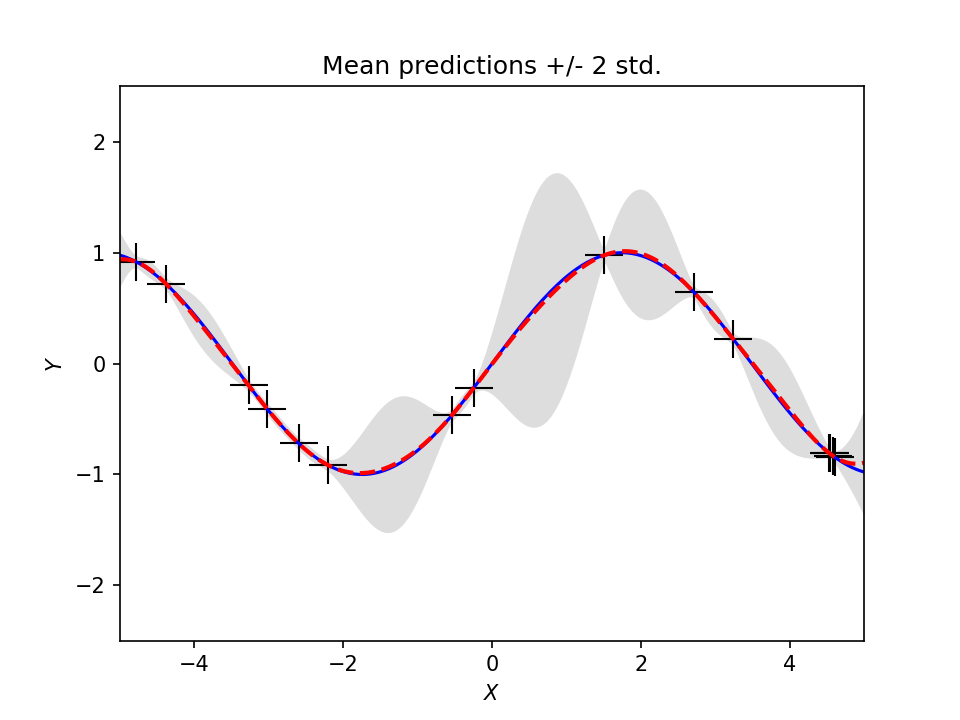

interactive(children=(FloatSlider(value=1.94, description='l_slider', max=4.0, min=0.1), FloatSlider(value=1.7…

In [68]:
## 1) Setup
N = 15         # number of existing observation points (training points) X
s = 0.0005    # noise variance sigma_X^2

X = np.random.uniform(-5, 5, size=(N,1))     # N training points 
y = f(X) + s*np.random.normal(0,np.sqrt(s),N) #observations (following true unknown function we wish to approx)

plot_post_slider(X,s,y)

## 5 Model Selection and Adaptation of Hyperparameters

Families of covariance functions have _hyperparameters_ whose values we must determine. This is _model selection_. The _training_ of a GP is the process of selecting a covariance function's parameters.

Links to look at later:
- https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Introduction%20to%20Bayesian%20Optimization%20with%20Hyperopt.ipynb
- https://nbviewer.org/github/fonnesbeck/Bios366/blob/master/notebooks/Section5_1-Gaussian-Processes.ipynb
- https://www.youtube.com/watch?v=JXdrq7--XV0
- https://gitlab.com/youtube-optimization-geeks/uncertainty-quantification/-/blob/main/coing_gpr_from_scratch_notebook.ipynb?ref_type=heads
- https://sandipanweb.wordpress.com/2020/12/08/gaussian-process-regression-with-python/
- https://peterroelants.github.io/posts/gaussian-process-tutorial/